In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


In [3]:
trainData = ImageDataGenerator()
trainingdt = trainData.flow_from_directory(directory='RealvsFake/Training', target_size=(224,224))


Found 101965 images belonging to 2 classes.


In [4]:
testData = ImageDataGenerator()
testingdt = testData.flow_from_directory(directory='RealvsFake/Testing', target_size=(224,224))


Found 20076 images belonging to 2 classes.


In [5]:
def preprocess(file_path):
        byte_img = tf.io.read_file(file_path)
        img = tf.io.decode_jpeg(byte_img)
        img = tf.image.resize(img, (224,224))
        img = img / 255.0
        return img

In [6]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [7]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='softplus'))

In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,900,482
Trainable params: 1,312,770
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
resnet_model.compile(optimizer=Adam(lr=3e-4),loss='binary_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(trainingdt, validation_data=testingdt, epochs=10, steps_per_epoch=100, validation_steps=10)

C:\Users\viola\anaconda3\envs\keras_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
100/100 [==============================] - 596s 6s/step - loss: 7.6012 - accuracy: 0.5175 - val_loss: 7.6553 - val_accuracy: 0.5469
Epoch 2/10
100/100 [==============================] - 725s 7s/step - loss: 7.6525 - accuracy: 0.5056 - val_loss: 7.6500 - val_accuracy: 0.4875
Epoch 3/10
100/100 [==============================] - 663s 7s/step - loss: 7.6481 - accuracy: 0.5153 - val_loss: 7.6464 - val_accuracy: 0.5437
Epoch 4/10
100/100 [==============================] - 651s 6s/step - loss: 7.6450 - accuracy: 0.5000 - val_loss: 7.6438 - val_accuracy: 0.4375
Epoch 5/10
100/100 [==============================] - 692s 7s/step - loss: 7.6427 - accuracy: 0.5128 - val_loss: 7.6417 - val_accuracy: 0.4719
Epoch 6/10
100/100 [==============================] - 723s 7s/step - loss: 7.6409 - accuracy: 0.5144 - val_loss: 7.6400 - val_accuracy: 0.4750
Epoch 7/10
100/100 [==============================] - 587s 6s/step - loss: 7.6393 - accuracy: 0.5019 - val_loss: 7.6386 - val_accuracy: 0.5312

In [10]:
resnet_model.save('resnet50SVMsoftplus.h5')

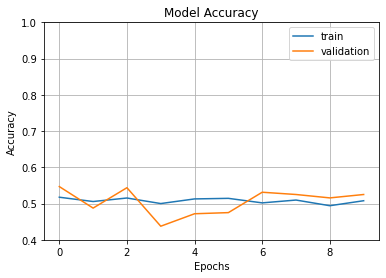

In [11]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

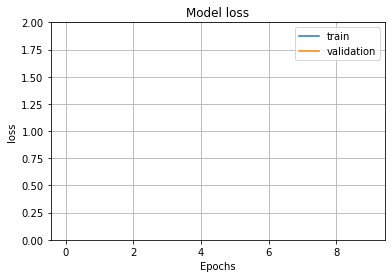

In [12]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=2)
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
steps_per_epoch = 100
predictions = resnet_model.predict(testingdt, steps= steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = testingdt.classes
class_labels = list(testingdt.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

ValueError: Found input variables with inconsistent numbers of samples: [20076, 3200]